# Histogram-based Outlier Score (HBOS)

In [10]:
import numpy as np
import pandas as pd
from pyod.models.hbos import HBOS
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from utils import *

# Generate data

In [11]:
X_train_pd, X_test_pd, y_train, y_test = data_generator()
X_train_pd.head()

,0,1,2,3,4,5
0,2.603910,2.907389,2.926608,3.011738,3.046527,2.549003
1,3.368960,3.253818,3.101950,2.619852,3.032668,3.141084
2,3.175317,2.868588,2.971171,3.296546,2.497034,2.880892
3,2.893902,2.834827,2.659174,2.829891,3.250861,3.321339
4,3.170353,3.224404,3.170562,2.945232,3.422810,3.405451


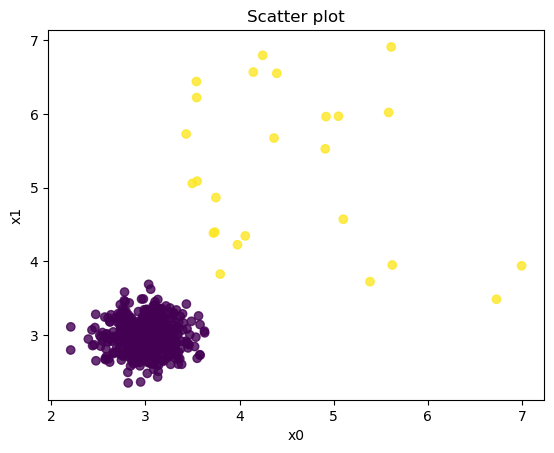

In [12]:
plot_data(X_train_pd, y_train)

# Modeling procedure

## Step 1: Build your model

In [13]:
n_bins = 50
hbos = HBOS(n_bins=n_bins, contamination=0.05)
hbos.fit(X_train_pd);

In [14]:
# Training data
y_train_scores = hbos.decision_function(X_train_pd)
y_train_pred = hbos.predict(X_train_pd)

# Test data
y_test_scores = hbos.decision_function(X_test_pd)
y_test_pred = hbos.predict(X_test_pd) # outlier labels (0 or 1)

In [15]:
stats_count_train = count_stat(y_train_pred)
stats_count_test = count_stat(y_test_pred)

# Threshold for the defined comtanimation rate
print("The threshold for the defined contamination rate:" , hbos.threshold_)
print("The training data:", stats_count_train)
print("The training data:", stats_count_train)

The threshold for the defined contamination rate: 5.563712646460526
The training data: {0: 475, 1: 25}
The training data: {0: 475, 1: 25}


## Step 2: Determine a reasonable treshold

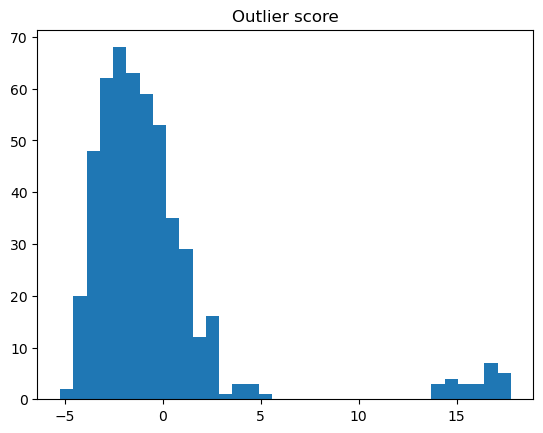

In [16]:
plt.hist(y_train_scores, bins="auto")
plt.title("Outlier score")
plt.show()

The histogram has a clear gap between 5.5 and 14.0, suggesting any value in this range can be an appropriate threshold. We
will choose the HBOS threshold.

## Step 3: Profile the normal and outlier groups

In [17]:
threshold = hbos.threshold_ # Or other value from the above histogram
feature_list = ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6']

descriptive_stat_threshold(X_train_pd, feature_list, y_train_scores, threshold).T

,0,1
Group,Normal,Outlier
Count,475,25
Count %,95.0,5.0
Feature_1,3.0,4.55
Feature_2,2.99,5.21
Feature_3,2.99,5.47
Feature_4,3.01,5.23
Feature_5,2.99,5.03
Feature_6,3.02,5.06
Anomaly_Score,-1.28,16.02


In [18]:
confusion_matrix(y_train, y_train_scores, threshold)

Pred,0,1
Actual,,
0.0,475,0
1.0,0,25


# Aggregate multiple models

In [20]:
# Test a range of binning
k_list = [5, 10, 15, 20, 25, 30, 50, 60, 75, 100]
n_clf = len(k_list)
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train_pd.shape[0], n_clf])
test_scores = np.zeros([X_test_pd.shape[0], n_clf])

# Modeling
for i in range(n_clf):
    k = k_list[i]
    hbos = HBOS(n_bins=k)
    hbos.fit(X_train_pd)
    # Store the results in each column:
    train_scores[:, i] = hbos.decision_function(X_train_pd)
    test_scores[:, i] = hbos.decision_function(X_test_pd)
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

In [21]:
# Combination by average
# The test_scores_norm is 500 x 10. The "average" function will take the average of the 10 columns. The result "y_by_average" is a single column:
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)

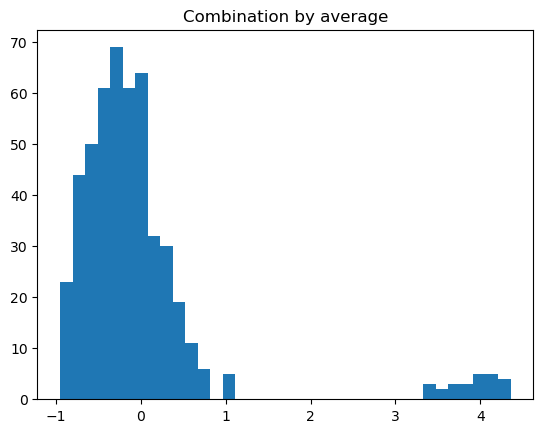

In [22]:
plt.hist(y_train_by_average, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

We will choose a threshold of 1.4.

In [26]:
descriptive_stat_threshold(X_train_pd, feature_list, y_train_by_average, threshold=1.4).T

,0,1
Group,Normal,Outlier
Count,475,25
Count %,95.0,5.0
Feature_1,3.0,4.55
Feature_2,2.99,5.21
Feature_3,2.99,5.47
Feature_4,3.01,5.23
Feature_5,2.99,5.03
Feature_6,3.02,5.06
Anomaly_Score,-0.21,3.92
